# Présentation du projet : 

## Contexte 

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


## Données 



Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

## Mission
### Contraintes


* Mettre en œuvre une approche non supervisée.
* Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
* Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
* Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
* Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

### Livrable attendu ici
Un notebook d’exploration comprenant une analyse univariée, une analyse multivariée, une réduction dimensionnelle et les différentes questions de recherches associées (non cleané, pour comprendre votre démarche).

# Ressources : 

## Les données et leur description :

Site d'extraction des données :

Traitement de texte (NLP) : 
* Le cours OC sur le traitement de text : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/
* 
* 
* 
* Les ressources compémentaires proposées dans le projet :
    * La doc sklearn : https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    * Article - overview extraction de mot-clé : https://jios.foi.hr/index.php/jios/article/view/938/724
    * Tuto Kaggle Word2Vec : https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words
    * Livre NLTK (Natural Language Toolkit) : http://www.nltk.org/book/
    * Slide de présentation séminaire sur "Topic Models" Thibaut THONET : https://www.irit.fr/IRIS-site/images/seminairs/Thonet2016.pdf

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P5/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P5/"

## my .py : 
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

## extract list of text :
from bs4 import BeautifulSoup
import re
# from sklearn.feature_extraction.s import s# import ENGLISH_STOP_WORDS

# from sklearn import model_selection 
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import linear_model

# from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import fowlkes_mallows_score
# from sklearn.metrics.pairwise import pairwise_kernels


# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LogisticRegression

# from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram


from bs4 import BeautifulSoup
import nltk
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.utils import tokenize
from gensim import corpora
from gensim import models
from gensim.models import FastText

## Plan du notebook :


Pour faciliter la lecture, il est possible de revenir à ce sommaire, en cliquant sur [back to menu](#menu) chaque fois qu'il apparaît. A partir de ce menu, il est possible de naviguer entre les parties en cliquant sur leur titre.


<a id ="menu"></a>
1. [Importer les données](#section1)
    1. [Preprocessing sur les tags](#section1.1)
        1. [Clustering non supervisé des tags](#section1.1.1)
        2. [Construction d'une variable retour y](#section1.1.2)
    2. [Preprocessing sur les titres/corpus](#section1.2)
        1. [De HTML à text](#section1.2.1)
        2. [Tokenization](#section1.2.2)
        3. [Stopwords](#section1.2.3)
        4. [Lemmatization](#section1.2.4)
    3. [Représentation des mots](#section1.3)
        1. [Bag of words](#section1.3.1)
        2. [tf-idf](#section1.3.2)
2. [Classification non supervisée](#section2)
    1. [whitening](#section2.1)
    2. [equalization](#section2.2)
    3. [modification de la taille des images](#section2.3)
    4. [data augmentation (mirroring, cropping...)](#section2.4)
    5. [automatisation du preprocess](#section2.5)

3. [Mon réseau CNN](#section3)
    1. [bibliographie pour réaliser ce travail](#section3.1)
          1. [modèles de réseau CNN](#section3.1.1)
          2. [fonction de cout](#section3.1.2)
          3. [adaptative Learning ](#section3.1.3)  
    2. [création du CNN](#section3.2)
          1. [préparation des données](#section3.2.1)
          2. [le CNN LeNet5 et les paramètres à fixer](#section3.2.2)
          3. [optimisation des paramètres](#section3.2.3)       
          4. [etude du taux d'apprentissage](#section3.2.4)
    3. [Optimisation des hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)](#section2.2)>


<a id ="section1"></a>
<!-- <a id ="section1.1"></a> -->

[back to menu](#menu)
# 1. Importer les données :
##  Première lecture


In [3]:
df1 = pd.read_csv(data_path + "QueryResults_Id_0_50000.csv")
df1 = df1.set_index("Id")#.iloc[:1000,:]
print(df1.shape)
df1.head(3)

(50000, 22)


,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
Id,,,,,,,,,,,,,,,,,,,,,
4,1,7.0,NaN,2008-07-31 21:42:52,NaN,727,58688.0,<p>I want to use a <code>Track-Bar</code> to c...,8.0,NaN,...,2021-02-26 03:31:15,2021-02-26 03:31:15,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,14.0,5,55.0,NaN,2012-10-31 16:42:47,CC BY-SA 4.0
6,1,31.0,NaN,2008-07-31 22:08:08,NaN,306,21663.0,<p>I have an absolutely positioned <code>div</...,9.0,NaN,...,2021-01-29 18:46:45,2021-01-29 18:46:45,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,7.0,0,12.0,NaN,NaN,CC BY-SA 4.0
7,2,NaN,4.0,2008-07-31 22:17:57,NaN,482,NaN,<p>An explicit cast to <code>double</code> lik...,9.0,NaN,...,2019-10-21 14:03:54,2019-10-21 14:03:54,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 4.0


Visiblement seuls trois colonnes vont avoir un intérêt pour cette étude. Il s'agit des colonnes "Title" et "Body" comme ensemble d'entrée, et "Tags" comme sortie.

In [4]:
title = df1["Title"]
body = df1["Body"]
tags = df1["Tags"]

Il sera peut-être judicieux d'utiliser d'autres colonnes correspondant à la réponse de la communauté pour voir si le post a été tagué correctement. Il s'agirait de faire un  filtre sur les données d'apprentissage, puisqu'on ne veut pas apprendre des questions mal taguées. 

Pour le moment je vais me satisfaire de cet ensemble d'apprentissage. Comme c'est la première fois que je fais du NLP, je vais d'abord regarder comment faire un prétraitement sur les titres (parce que plus petit ensemble)

<a id ="section1.1"></a>

[back to menu](#menu)

## 1.A Preprocessing sur les tags 

Dans le projet, il est demandé de traiter le problème de deux manières : 
* Non supervisé : je pense faire appel au [module tags de la bibliothèque python nltk](http://www.nltk.org/api/nltk.tag.html#module-nltk.tag). Il pourra être pertinent de comparer cette approche avec les tags attribué par les internautes, ce pourquoi le preprocess des tags me paraissait pertinent à faire en premier lieu.
* Supervisé : pour cela, j'aurai besoin d'avoir extrait les tags des posts de slackoverflow pour les apprendre/tester les modèles. C'est ce que je compte faire dans cette partie.

Les tags sont dans un format entre balises, je vais les mettre dans une pd.DataFrame avec en colonne les différents tags et en ligne les posts. La matrice sera rempli du nombre d'occurence des tags. Elle sera donc sparse. 

In [5]:
tags = tags[~tags.isna()]
## test separation des tags entre balise
import re
print("test sur un post :", re.findall(r"\<([^>]*)",tags.iloc[0]))

## creation de la pd.DataFrame
df_tags = {}
for idx in tags.index : #[:1000] : 
    list_tags = re.findall(r"\<([^>]*)",tags.loc[idx])
    df_tags[idx] = pd.get_dummies(list_tags).sum()
df_tags = pd.DataFrame(df_tags).transpose()
df_tags = df_tags.fillna(0)
df_tags.head()

test sur un post : ['c#', 'floating-point', 'type-conversion', 'double', 'decimal']


,.htaccess,.htpasswd,.net,.net-1.0,.net-1.1,.net-2.0,.net-3.0,.net-3.5,.net-assembly,.net-attributes,...,zeroconf,zfs,zip,zipcode,zipinputstream,zipoutputstream,zlib,zos,zsh,zxspectrum
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


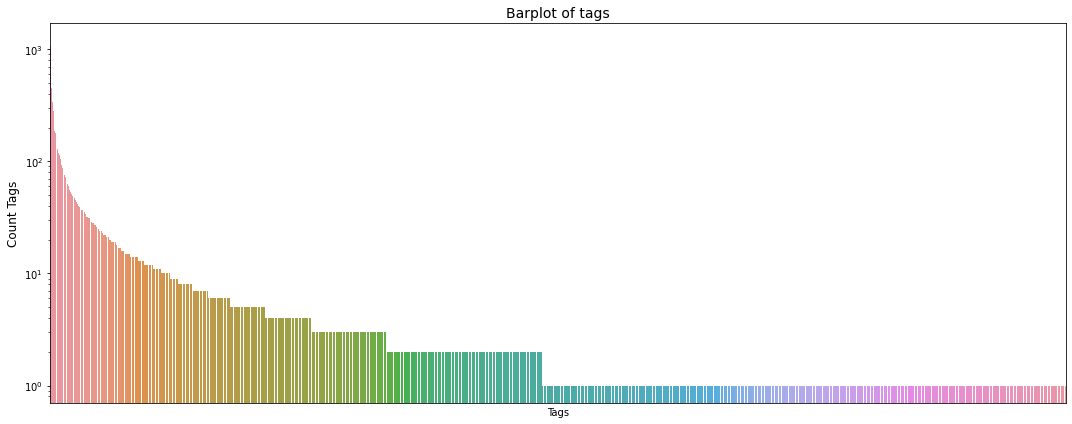

In [6]:
# df_tags.plot(kind="bar")
plt.rcParams["figure.figsize"] = (15,6)
tmp = df_tags.sum(axis=0).sort_values(ascending=False)
sns.barplot(y=tmp.values,x=tmp.index)
plt.xlabel("Tags", fontsize=10)
# plt.xticks(rotation=90, fontsize=6) # print xticks
plt.xticks([]) # remove xticks
plt.ylabel("Count Tags", fontsize=12)
plt.yscale("log")
plt.title("Barplot of tags", fontsize=14)
plt.tight_layout()
plt.savefig(res_path+"figures/"+"barplot_tags.jpg")
plt.show()

<a id ="section1.1.1"></a>

[back to menu](#menu)

### 1.A.a Clustering non supervisé des tags

Un travail à part de clustering des tags (voir la première version du notebook) donne ces résultas :

#### Singletons 

In [8]:
with open(res_path+"tags_cluster"+".pkl", "rb") as f :
    dict_tag_clusters = pickle.load(f)
dict_tag_clusters

{1: array(['sinclair', 'z80', 'zxspectrum'], dtype=object),
 2: array(['cab', 'scsf'], dtype=object),
 3: array(['indexing-service', 'modi', 'ocr', 'tesseract'], dtype=object),
 4: array(['alphablending', 'bezier', 'bitmap', 'bounding-box', 'c++11', 'cg',
        'compositing', 'curve', 'dds-format', 'direct3d', 'directdraw',
        'directx', 'dirtyrectangle', 'fbo', 'framebuffer', 'glew',
        'global', 'global-state', 'glut', 'graphics', 'hotkeys',
        'inequality', 'interpolation', 'java-3d', 'lighting',
        'multisampling', 'opengl', 'psql', 'pyglet', 'scrollwheel',
        'state', 'textures', 'variables', 'vbo'], dtype=object),
 5: array(['binary', 'binary-data', 'binary-tree', 'bit-manipulation',
        'boolean-logic', 'camelcasing', 'coding-style', 'final', 'integer',
        'logic', 'pascalcasing', 'perl-critic', 'polymorphism',
        'recursion', 'red-black-tree', 'sign', 'string-parsing',
        'syntax-checking', 'synthesis', 'tail-recursion', 'this',
   

Il y a  42  singleton


Text(0.5, 1.0, "Nombre d'apparition des tags formant les singletons")

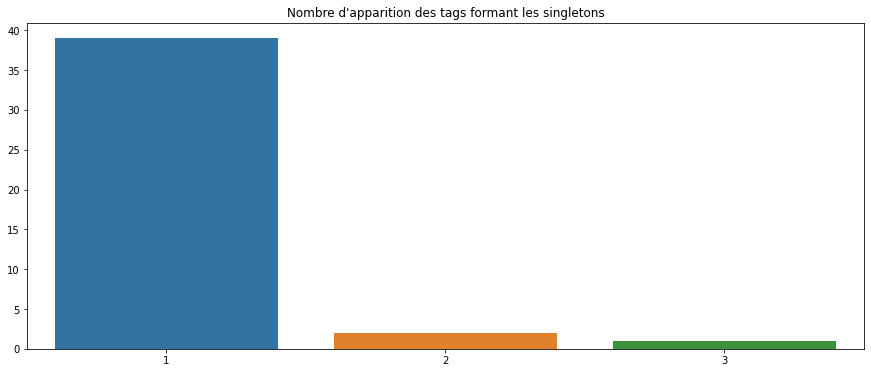

In [9]:
## etude des singletons : 
singleton_cluster = [k for k in dict_tag_clusters.keys() if len(dict_tag_clusters[k])==1]
print("Il y a ", len(singleton_cluster), " singleton")
singleton_tags = [dict_tag_clusters[k][0] for k in singleton_cluster]
tmp = df_tags.loc[:,singleton_tags].sum(axis=0)
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.title("Nombre d'apparition des tags formant les singletons")

Ce sont des tags qui n'apparaissent qu'une ou deux fois dans l'ensemble d'apprentissage. Comparons cela à la répartition des tags de façon générale : 

Text(0.5, 1.0, "Nombre d'apparition des tags")

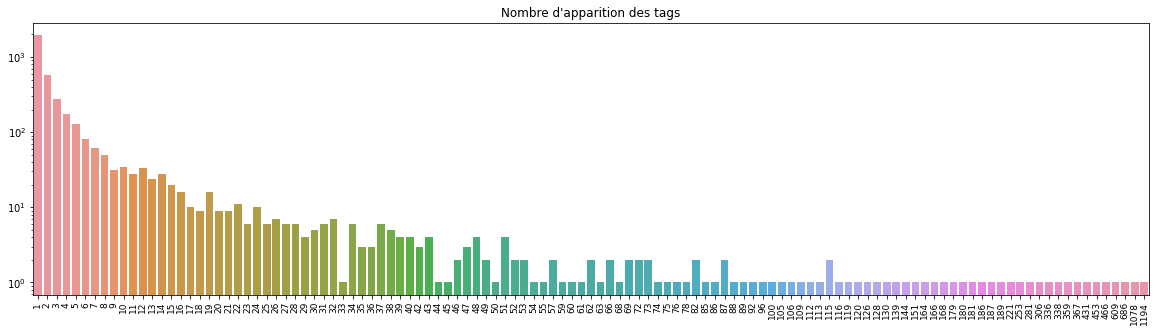

In [10]:
tmp = df_tags.sum(axis=0)
plt.figure(figsize = (20,5))
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.xticks(rotation=90, fontsize = 9)
plt.yscale("log")
plt.title("Nombre d'apparition des tags")

Text(0.5, 1.0, 'Nombre de tags pour les posts')

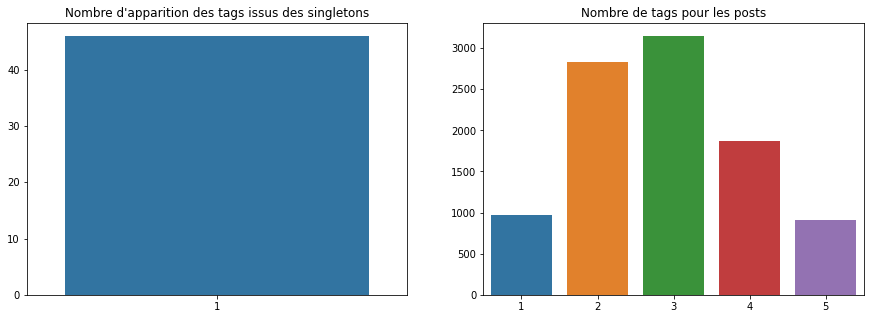

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
posts_from_singleton = df_tags[df_tags.loc[:,singleton_tags].sum(axis=1)>=1]
tmp = posts_from_singleton.sum(axis=1)
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.title("Nombre d'apparition des tags issus des singletons")

plt.subplot(1,2,2)
tmp = df_tags.sum(axis=1)
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.title("Nombre de tags pour les posts")

Les singletons sont donc formés des posts n'ayant qu'un seul tag, qui n'apparait pas dans les autres posts. 


#### Cluster non singletons
Passons à l'étude des autres clusters :

Il y a  68  clusters non singleton


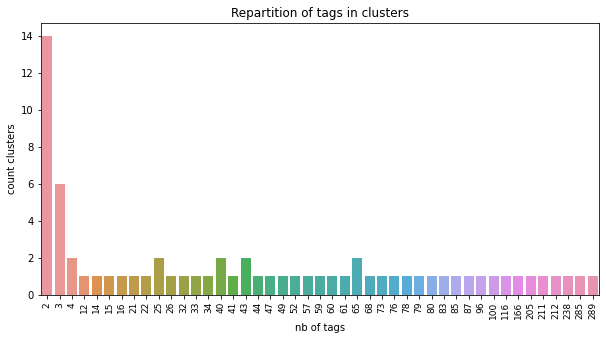

count     68.000000
mean      54.735294
std       68.342120
min        2.000000
25%        3.000000
50%       37.000000
75%       73.750000
max      289.000000
dtype: float64

In [12]:
cluster = [k for k in dict_tag_clusters.keys() if len(dict_tag_clusters[k])>1]
print("Il y a ", len(cluster), " clusters non singleton")
cluster_list_tags = [list(dict_tag_clusters[k]) for k in cluster]
distrib_cluster = {}
for k in cluster :
    distrib_cluster[k] = len(dict_tag_clusters[k])
distrib_cluster = pd.Series(distrib_cluster)
plt.figure(figsize = (10,5))
tmp = distrib_cluster.value_counts()
sns.barplot(x = [int(i) for i in tmp.index],
            y = tmp.values)
plt.xticks(rotation=90, fontsize = 9)
plt.xlabel("nb of tags")
plt.ylabel("count clusters")
plt.title("Repartition of tags in clusters")
plt.show()
distrib_cluster.describe()

In [13]:
big_clusters = distrib_cluster[distrib_cluster>100].index.values
data_boxplot = pd.DataFrame(columns=["index", "post_count", "cluster"])
for cluster in big_clusters :
    tags = dict_tag_clusters[cluster]
    ## extract posts where tag is present
    count_posts = [sum(df_tags[tag]==1) for tag in tags]
    count_posts = pd.Series(count_posts, index=tags, name = "post_count")
    count_posts = count_posts.reset_index()
    count_posts.at[:,"cluster"] =  cluster
    data_boxplot = pd.concat([data_boxplot,count_posts], join='inner', ignore_index=True, 
                             verify_integrity=True, sort=False, copy=True)

Text(0.5, 1.0, 'Nombre de posts où apparaissent les tags')

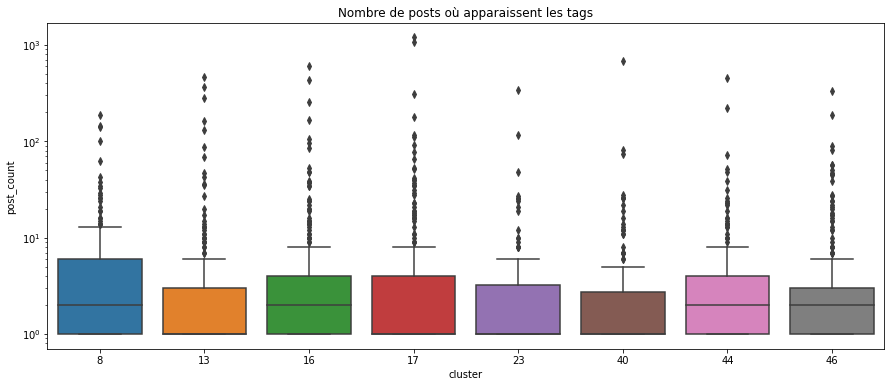

In [16]:
sns.boxplot(x="cluster", y="post_count", data=data_boxplot)
plt.yscale("log")
plt.title("Nombre de posts où apparaissent les tags")

Une grande partie des clusters sont de petite taille. Je vais regarder la répartition pour les plus gros clusters, ceux qui ont plus de 100 tags. Re

cluster 8


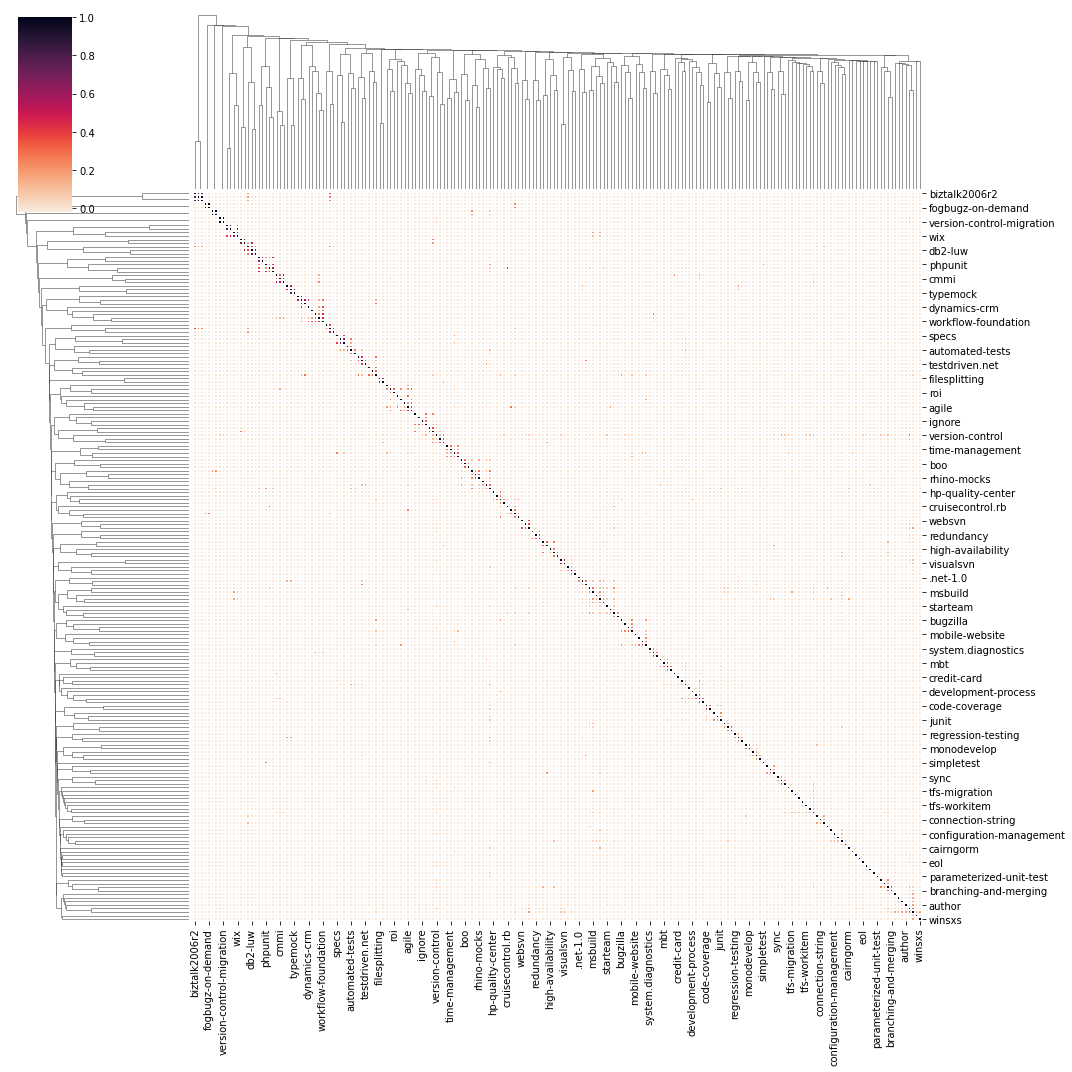

cluster 13


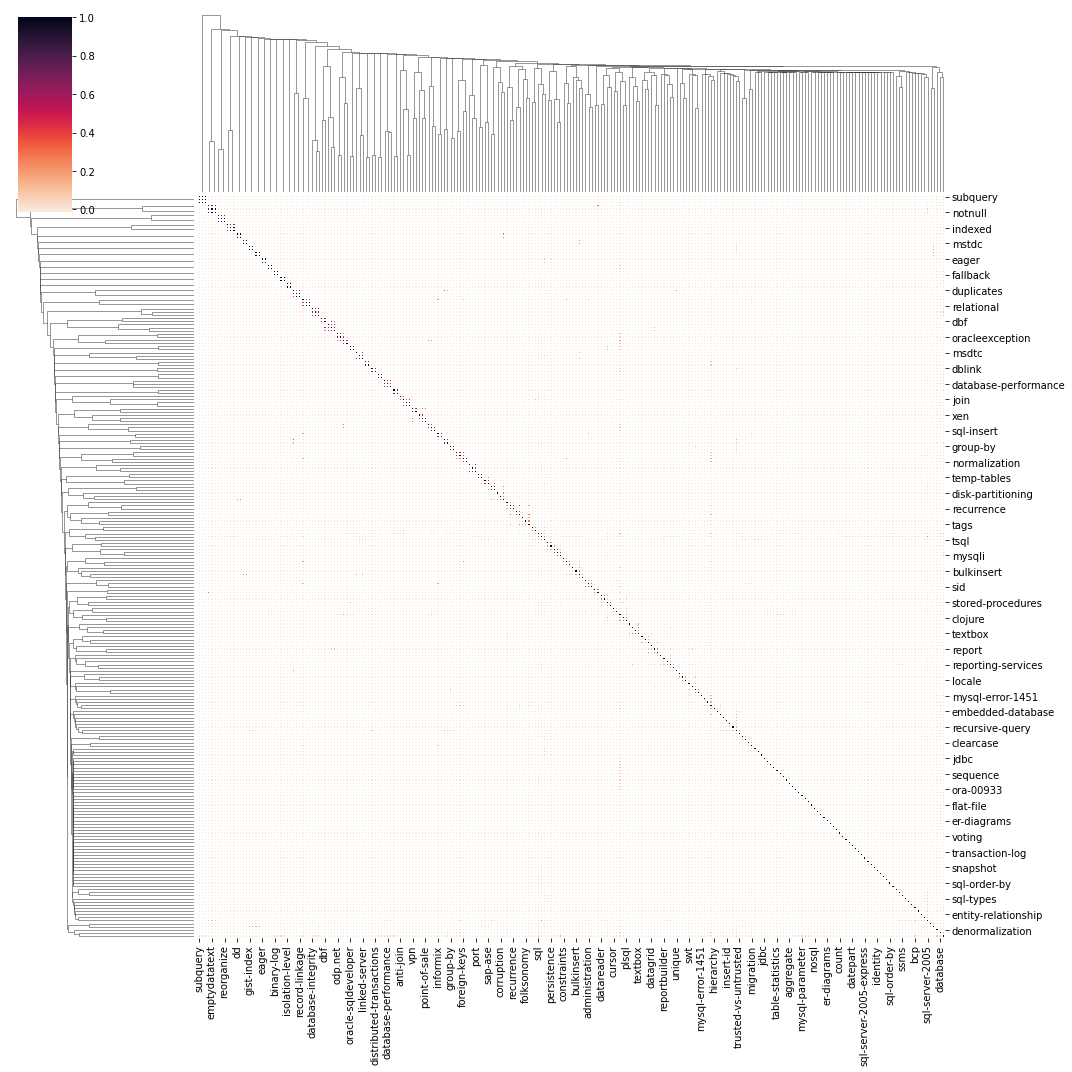

cluster 16


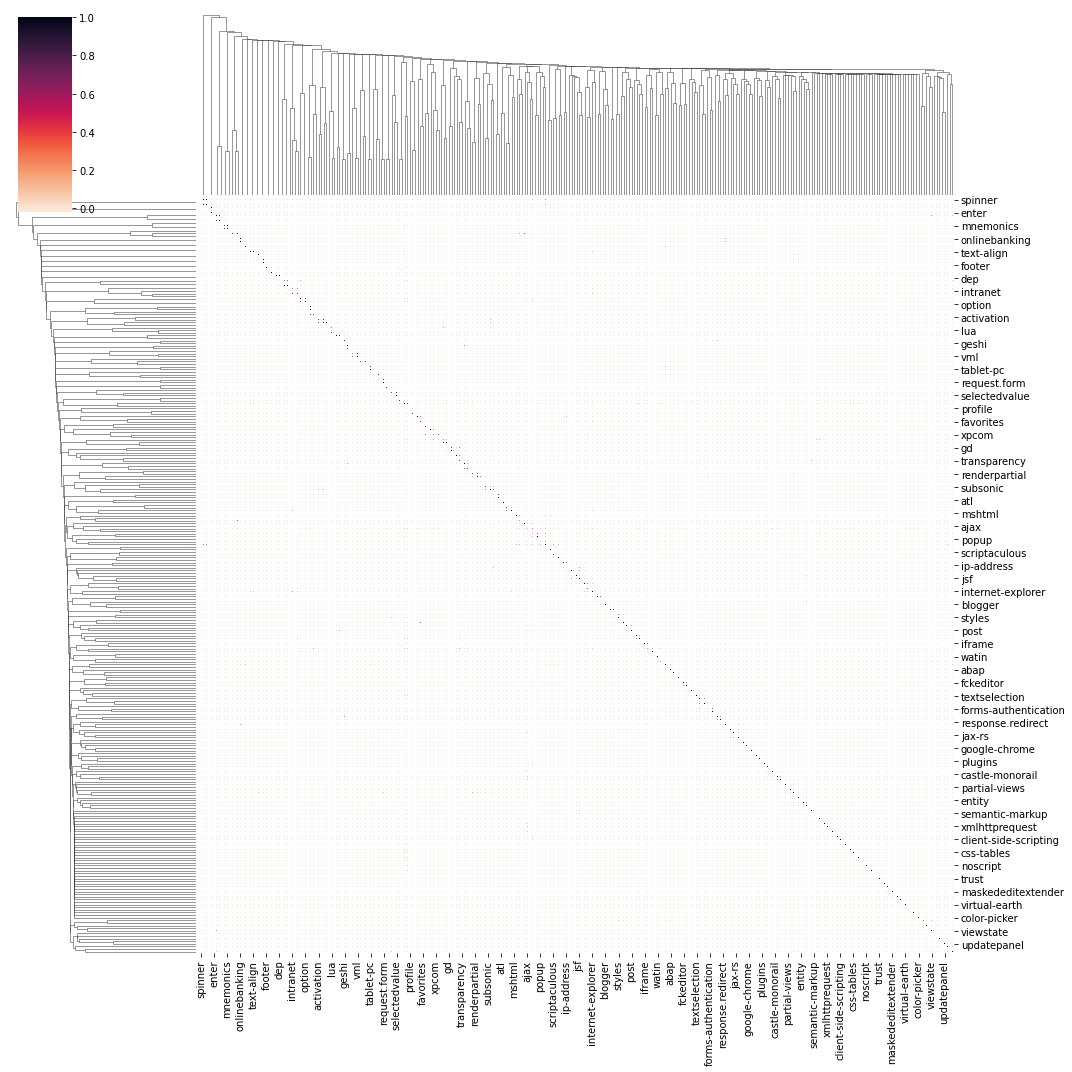

cluster 17


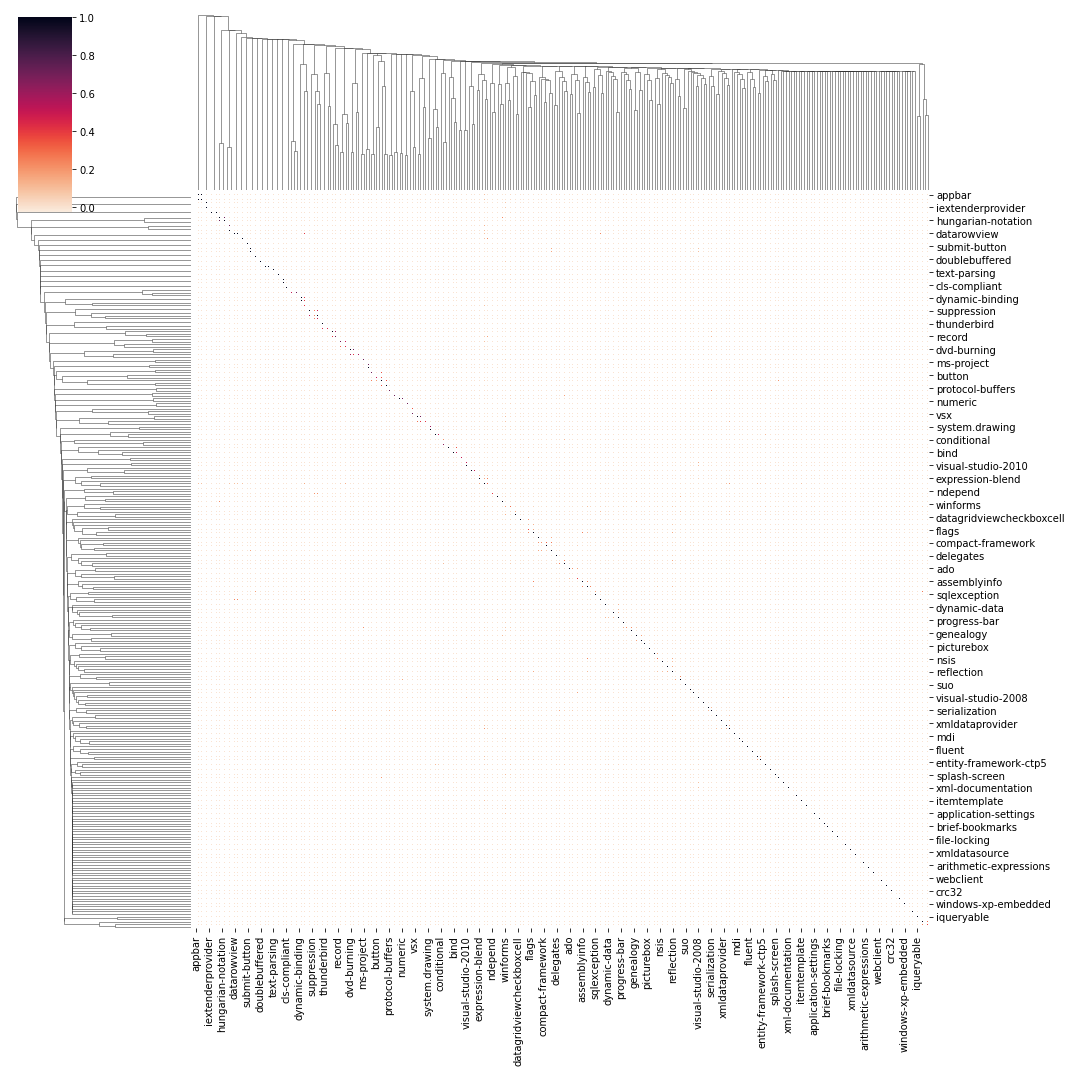

cluster 23


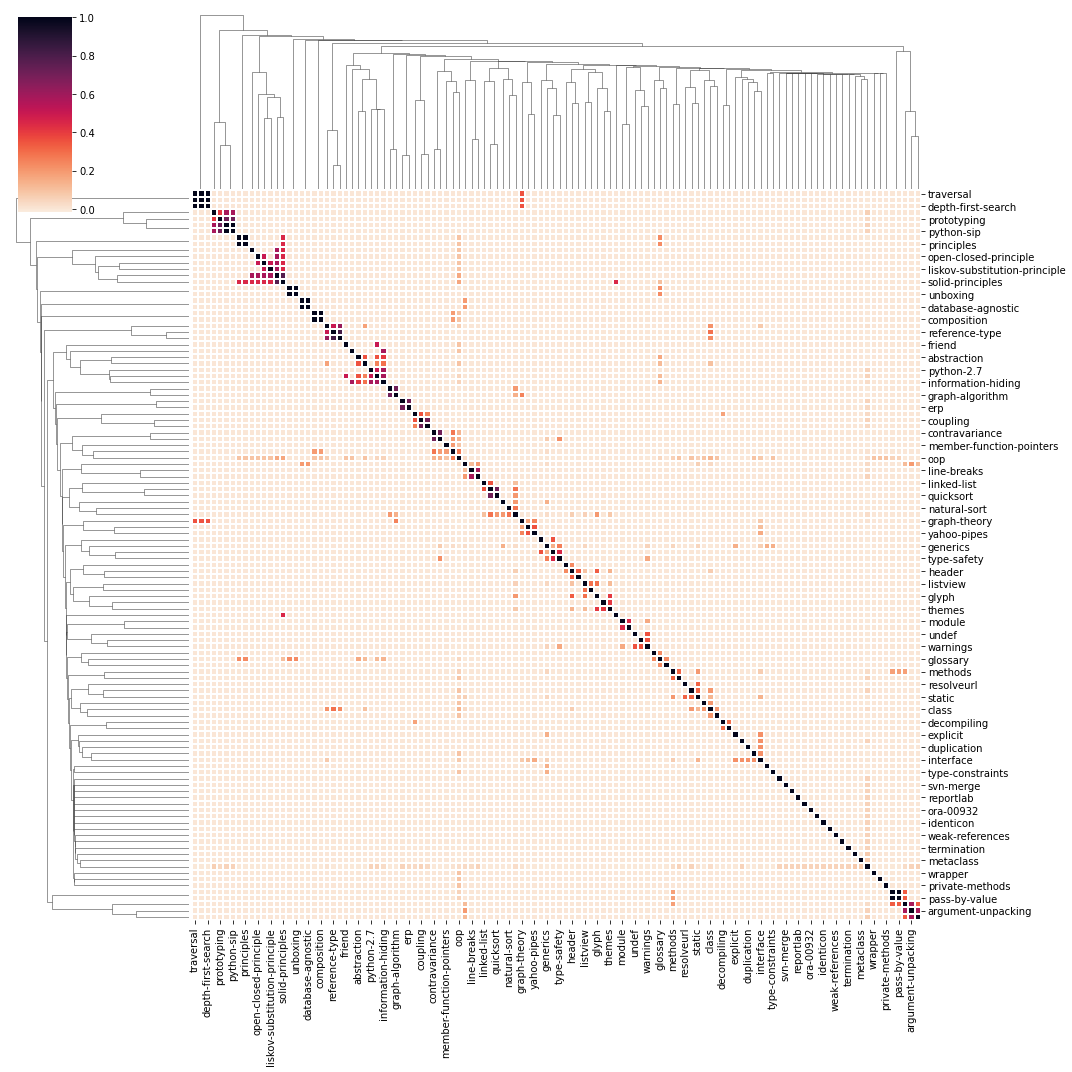

cluster 40


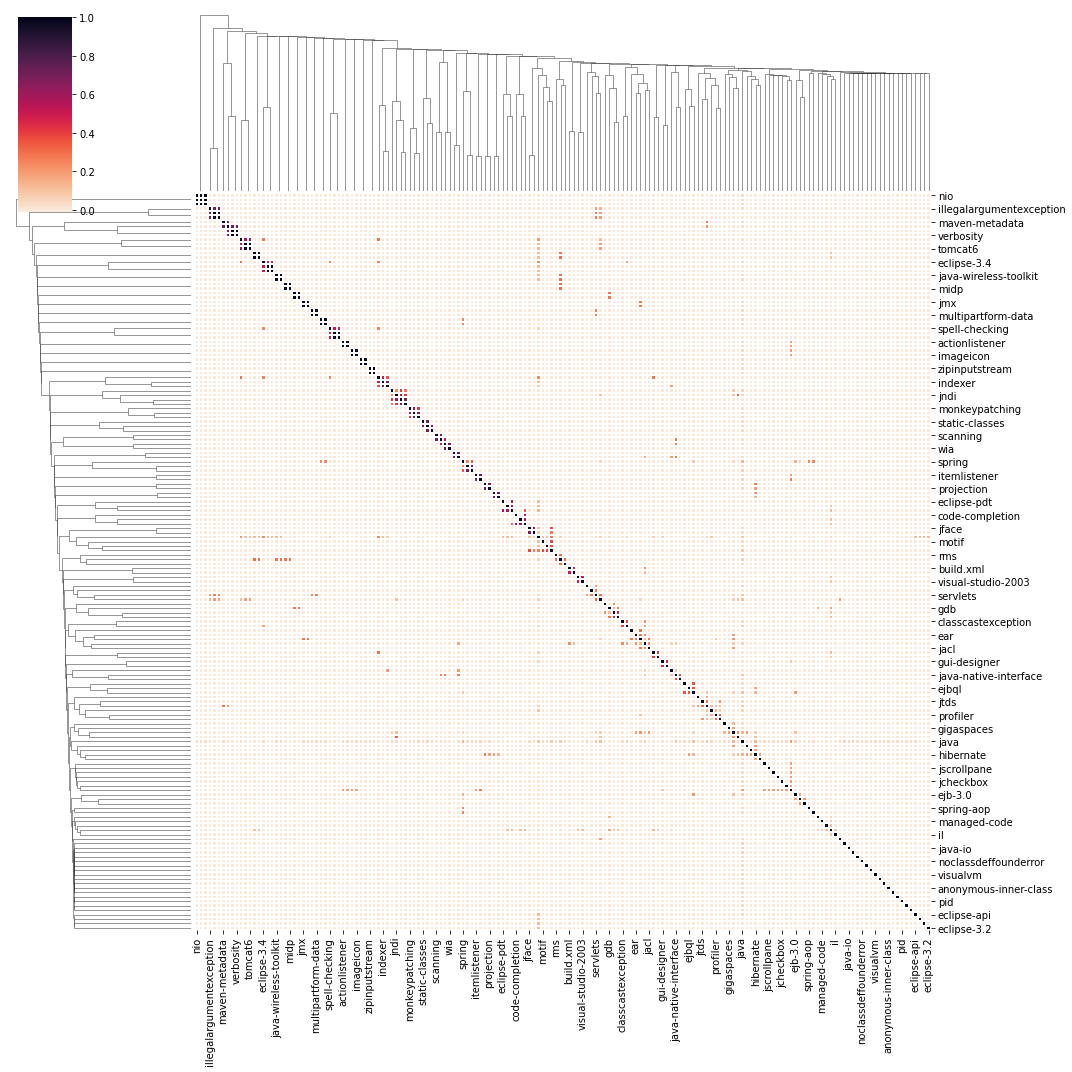

cluster 44


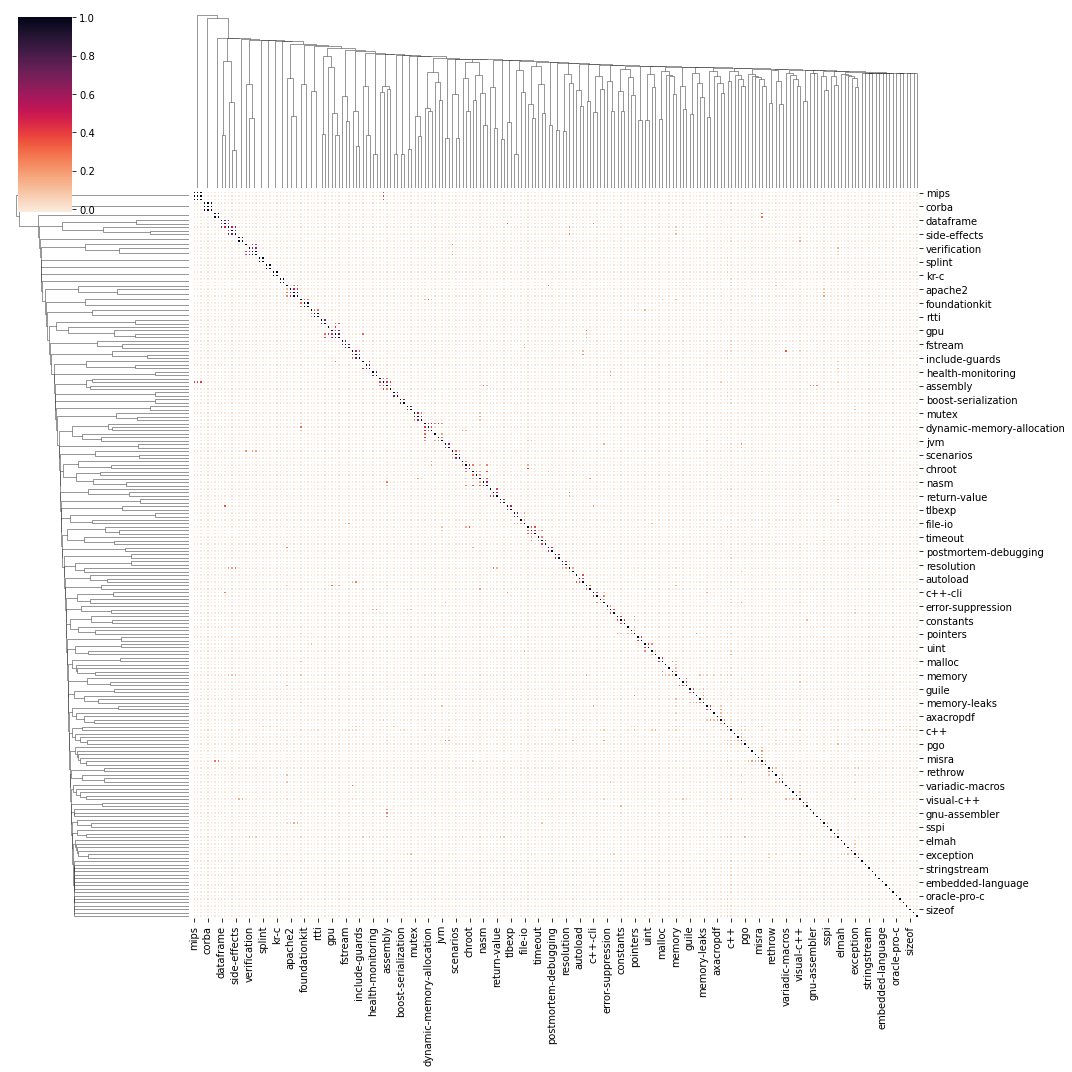

cluster 46


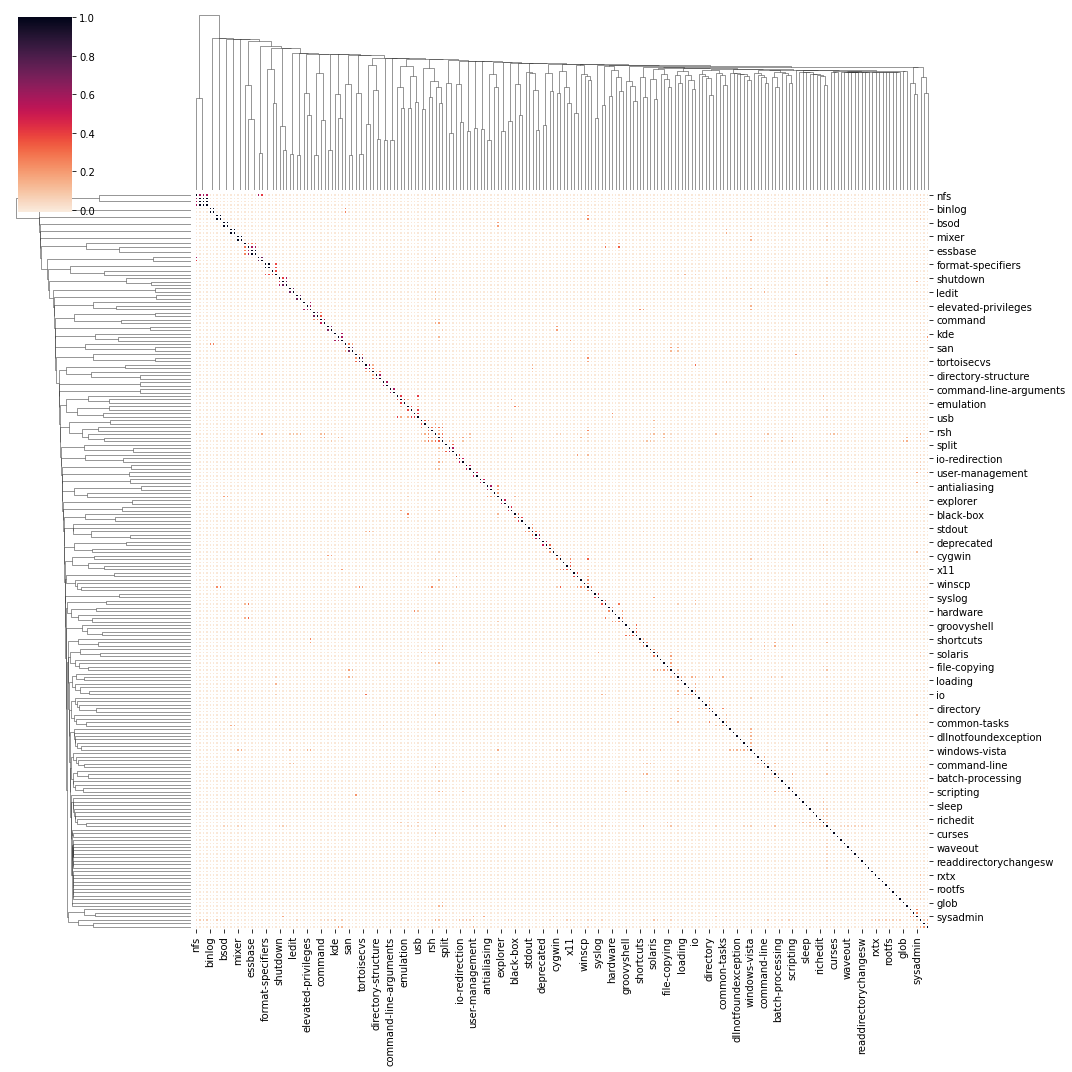

In [19]:
for cluster in big_clusters :
    print("cluster", cluster)
    tags = dict_tag_clusters[cluster]
    df_cluster = df_tags[tags]
    corr_matrix = df_cluster.corr("kendall")
    sns.clustermap(corr_matrix, cmap=sns.color_palette("rocket_r", as_cmap=True), 
                annot=False,linewidths=0.1, fmt='.2f',
                figsize=(15, 15))
    plt.show()

C'est assez étonnant que la structure soit si peu lisible dans les matrice de corrélation intra-clusters... 

<a id ="section1.1.2"></a>

[back to menu](#menu)

### 1.A.b Construction d'une variable retour y

Pour avancer dans le projet, il faut au moins que j'extrait une variable retour. Pour cela, je propose de prendre le tag le plus fréquent. 

In [20]:
max_tag_index = df_tags.sum(axis=0).argmax()
print("Il s'agira donc de prédire si le tag ", 
      df_tags.iloc[:, max_tag_index].name,
      "est pertinent pour le post (",
     df_tags.iloc[:, max_tag_index].sum(),
     "occurences).")
df_tags.shape

Il s'agira donc de prédire si le tag  c# est pertinent pour le post ( 1194.0 occurences).


(9729, 3764)

On pourra alors voir l'apprentissage tag par tag. Mon idée initale était de réussir à regrouper les tags par sémentique : un plan langage, un plan "quoi" (affichage, question math, représentation ...), ... et faire un apprentissage multi-niveau sur chaque classe. 

In [21]:
y_tag_name = df_tags.iloc[:, max_tag_index].name
y = df_tags[y_tag_name].fillna(0)
y

4        1.0
6        0.0
9        1.0
11       1.0
13       0.0
        ... 
86797    0.0
86800    0.0
86824    0.0
86849    0.0
86863    0.0
Name: c#, Length: 9729, dtype: float64

<a id ="section1.2"></a>
<a id ="section1.2.1"></a>

[back to menu](#menu)

## 1.B  Preprocessing sur les titres/corpus

J'ai choisi de commencer par suivre les étapes [du cours d'OpenClassRoom sur les traitement textes](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles). 

### Récupération et exploration du corpus de texte 
Je ne suis pas concernée par la partie "scrap" puisque j'ai déjà mon texte. 

Néansmoins, il y a deux points nécessaires à traiter a ce stade : 
1. Il faut sortir de la syntaxe html pour avoir un format text. Les balises de code semblent importante à garder, ne serait-ce que parce que certaines contiennent le langage de programmation.
2. je vais essayer d'insérer les titles dans les corpus, car il y a {{title.isna().sum()/title.shape[0]*100}}$\%$ de valeurs maquantes pour les titles. 

### 1.B.a  De HTML à text

In [22]:
body.iloc[0]

'<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<pre class="lang-none prettyprint-override"><code>Cannot implicitly convert type decimal to double\n</code></pre>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n'

In [23]:
def extract_text_btw_html(html):
#     html = title_+body_
    soup = BeautifulSoup(html)
    for script in soup(["script", "style"]):
        script.decompose()
    return(list(soup.stripped_strings))

# Use regular expressions to do a find-and-replace
def letter_only(my_text):
    return(re.sub("[^a-zA-Z]",   # The pattern to search for
                      " ",       # The pattern to replace it with
                      my_text ))  # The text to search

def from_list_of_sentences_to_tokens(list_text):
    tokens=[]
    for text in list_text[:20] :
        ## soit le code fait mqin depuis tuto kaggle
        text = letter_only(text.lower())
        text_token = nltk.word_tokenize(text)
#         ## soit tout fonction tout pret de nltk
#         text_token = tokenizer.tokenize(text.lower())
        
        tokens = tokens + text_token
    return(tokens)

In [24]:
# nltk.download('punkt')
posts = {}
posts_tokens = {}
for idx in body.index : 
    body_ = body.loc[idx]
    title_ = title.loc[idx]
    if pd.isna(title_) :
        text = str(body_)
    else :
        text = title_ + body_
    list_text = extract_text_btw_html(text)
    posts[idx]=  ' '.join(list_text)
    tokens = from_list_of_sentences_to_tokens(list_text)
    posts_tokens[idx] = tokens

In [25]:
print(posts[4])
print(posts_tokens[4])

How to convert a Decimal to a Double in C#? I want to use a Track-Bar to change a Form 's opacity. This is my code: decimal trans = trackBar1.Value / 5000;
this.Opacity = trans; When I build the application, it gives the following error: Cannot implicitly convert type decimal to double I have tried using trans and double , but then the Control doesn't work. This code worked fine in a past VB.NET project.
['how', 'to', 'convert', 'a', 'decimal', 'to', 'a', 'double', 'in', 'c', 'i', 'want', 'to', 'use', 'a', 'track', 'bar', 'to', 'change', 'a', 'form', 's', 'opacity', 'this', 'is', 'my', 'code', 'decimal', 'trans', 'trackbar', 'value', 'this', 'opacity', 'trans', 'when', 'i', 'build', 'the', 'application', 'it', 'gives', 'the', 'following', 'error', 'can', 'not', 'implicitly', 'convert', 'type', 'decimal', 'to', 'double', 'i', 'have', 'tried', 'using', 'trans', 'and', 'double', 'but', 'then', 'the', 'control', 'doesn', 't', 'work', 'this', 'code', 'worked', 'fine', 'in', 'a', 'past', 'vb

Maintenant que mes mots sont dans un dictionnaire de liste de mot, c'est à dire de tokens (de la même forme que dans le cours d'OC), je vais pouvoir reprendre des bouts de code de le cours pour avancer plus vite. 

<a id ="section1.2.2"></a>
[back to menu](#menu)

### 1.B.b Tokenization 

In [26]:
# tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats(list_tokens):
    corpora = list_tokens.copy()
    stats, freq = dict(), dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())} 
    return (freq, stats)

# Récupération des comptages
corpora = posts_tokens.copy()
freq, stats = freq_stats(posts_tokens)
df_tokens_stats = pd.DataFrame.from_dict(stats, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

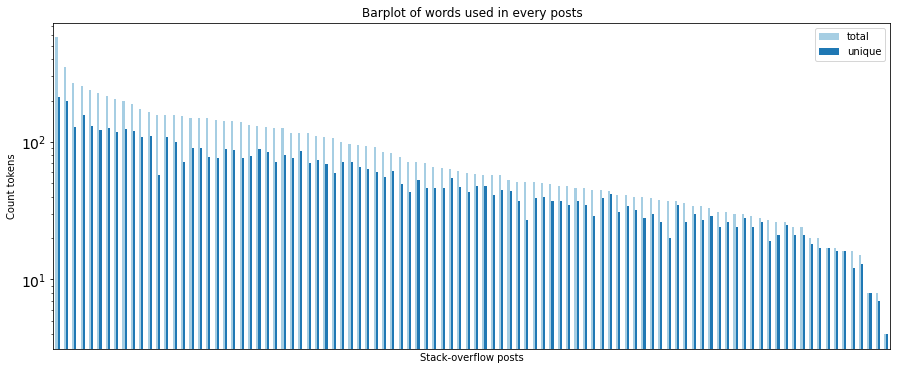

In [28]:
def plot_tokens_stats(df_tokens, figname=None):
    nb_colors = df_tokens.shape[1]
    df_tokens.plot(kind='bar', color=sns.color_palette("Paired", nb_colors),
                         title='Barplot of words used in every posts',
                         fontsize = 14,)
    plt.xticks([])
    plt.yscale("log")
    plt.xlabel("Stack-overflow posts")
    plt.ylabel("Count tokens")
    if figname is not None :
        plt.savefig(figname)
    plt.show()

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens1.jpg"
tmp = df_tokens_stats.sample(100).sort_values("total", ascending=False)
plot_tokens_stats(tmp, figname=figname)

Je trouve beaucoup trop lente la fonction "plot" de "pandas.DataFrame", et quitte à faire une fonction pour la lancer à plusieurs endroits, autant qu'elle soit plus rapide à l'exécution.

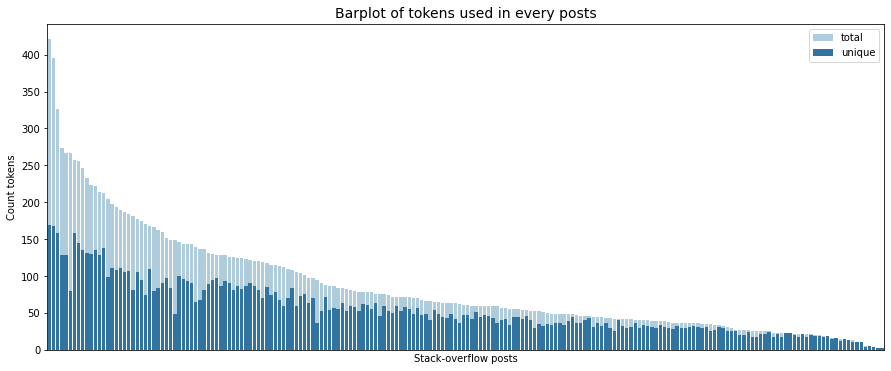

In [29]:
df_tokens = df_tokens_stats.sample(100)
def plot_tokens_stats(df_tokens, figname=None, ylog=False):
    df_tokens = df_tokens.sort_values("total", ascending=False)
    df_tokens = df_tokens.reset_index()
    nb_colors = df_tokens.shape[1]-1
    palette=sns.color_palette("Paired", nb_colors)
    for i,var in enumerate(df_tokens.columns[1:]):
        var_color = palette[i] 
        sns.barplot(x = "index", y = var, data=df_tokens,
                    order=df_tokens["index"],
                    color=var_color, label=var, 
                    log=ylog)
    plt.legend()
    plt.title('Barplot of tokens used in every posts',fontsize = 14)
    plt.xticks([])
#     plt.yscale("log")
    plt.xlabel("Stack-overflow posts")
    plt.ylabel("Count tokens")
    if figname is not None :
        plt.savefig(figname)
    plt.show()
# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens1.jpg"
sample_token_stat = df_tokens_stats.sample(200)
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)

In fine, ce qui va nous intéresser n'est pas la répartition des mots dans les posts, mais la répartition des mots pour les différents tags. Néansmoins, comme chaque post a plusieurs tags, il me parait bien plus pertinent de faire le nettoyage de ces tokens tel quel, et afficher le résultat par tags a posteriori (pas comme dans le TP, où les tokens sont affichés par artististe). 


<a id ="section1.2.3"></a>
[back to menu](#menu)

### 1.B.c Stopwords

Il ne me parait donc pas pertinent, comme dans le TP, de regarder ce que donne le même bar-plot, en retirant les mots en doublon (ici on n'a pas regroupé les tokens autre que pas post). Je propose de d'abbord faire les étapes de nettoyage et normalisation.

In [30]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus d'artistes
freq_totale = nltk.Counter()
for k, v in corpora.items():
    freq_totale += freq[k]

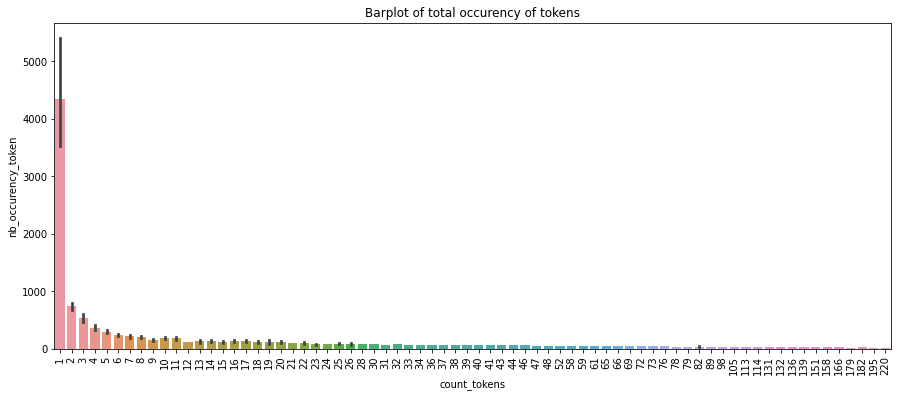

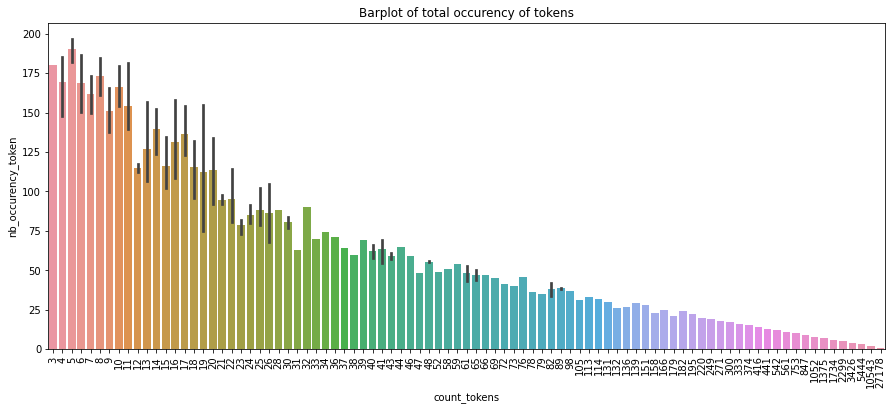

In [31]:
## Choix du seuil pour le nombre d'apparition des mots les plus frequents :
freq_count = pd.Series(freq_totale).value_counts()
freq_count = freq_count.reset_index()
freq_count = freq_count.rename(columns={"index":"nb_occurency_token", 
                                        0:"count_tokens"})
freq_count = freq_count.sort_values("count_tokens", ascending=False)
## drop non-freq words :
not_freq_tokens = freq_count[freq_count["nb_occurency_token"] <20].index
# freq_count = freq_count.drop(index=not_freq_tokens)
sns.barplot(data=freq_count.drop(index=not_freq_tokens), y="nb_occurency_token", x="count_tokens")
plt.title("Barplot of total occurency of tokens")
plt.xticks(rotation=90)
plt.show()
very_freq_tokens = freq_count[freq_count["nb_occurency_token"] >200].index
# freq_count = freq_count.drop(index=very_freq_tokens)
sns.barplot(data= freq_count.drop(index=very_freq_tokens), 
            y="nb_occurency_token", x="count_tokens")
plt.title("Barplot of total occurency of tokens")
plt.xticks(rotation=90)
plt.show()

Je fixe à 120 mots les plus fréquents : 

In [32]:
## Deuxièmement on extrait les mots les plus fréquents :
high_freq_token = [a_tuple[0] for a_tuple in freq_totale.most_common(120)]

In [33]:
## Troisièmement, on ajoute ces mots fréquents aux stopwords de nltk :
# nltk.download('stopwords')
sw = set()
sw.update(high_freq_token)
sw.update(tuple(nltk.corpus.stopwords.words('english')))


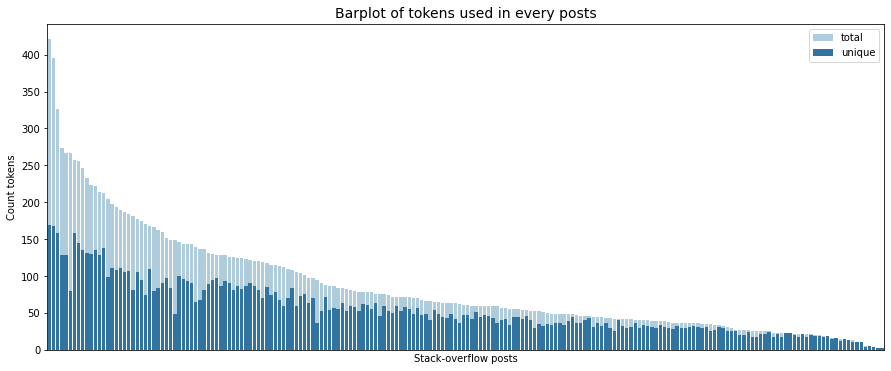

In [34]:
def freq_stats_corpora(list_tokens, stopwords=[]):
    stats, freq, corpora = dict(), dict(), dict()
    for k, v in list_tokens.items():
        corpora[k] = [w for w in list_tokens[k] if w not in list(stopwords)] 
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())} 
    return (freq, stats, corpora)

# Récupération des comptages
corpora = posts_tokens.copy()
freq2, stats2, corpora2 = freq_stats_corpora(posts_tokens, sw)
df_tokens_stats = pd.DataFrame.from_dict(stats2, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens2_stopwords.jpg"
sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)


<a id ="section1.2.4"></a>
[back to menu](#menu)

### 1.B.d Lemmatization 
Pour la partie de lemmatisation, comme le cours d'OC ne proposait qu'une radicalisation (car le texte était en français dans l'exemple), je me suis plutôt intéressée au [tuto de Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-1-for-beginners-bag-of-words). Après avoir creusé un peu plus, comme je n'avais pas plus d'information, et surtout que le stemming a l'air assez puissant et très bien décrit, je me suis finalement lancé là-dedans 

In [35]:

stemmer = EnglishStemmer()

def freq_stats_corpora3(list_tokens,stopwords=[]):     
    stats, freq = dict(), dict()
    corpora = list_tokens.copy()
    for idx in corpora.keys() :
        tokens = corpora[idx]
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
        tokens = [stemmer.stem(w) for w in tokens]
        corpora[idx] = tokens
        freq[idx] = fq = nltk.FreqDist(tokens)
        stats[idx] = {'total': len(tokens), 'unique': len(fq.keys())}
    return (freq, stats, corpora)


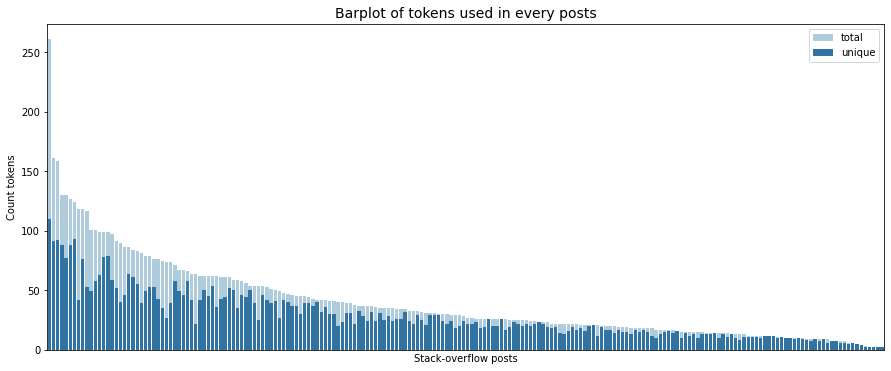

In [36]:
freq3, stats3, corpora3 = freq_stats_corpora3(posts_tokens, stopwords=sw)

df_tokens_stats = pd.DataFrame.from_dict(stats3, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens3_radical.jpg"
sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)

Pour la lemmatisation, j'ai trouvé [ce tuto](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) qui propose une implémentation assez claire. Il y avait des erreurs (une utilisation dépréciée), j'ai donc fini par aller [sur la page du paquet](https://spacy.io/). J'ai comparé le traitement 

In [37]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Process on a post to test the spacy syntax : 
text = " ".join(posts_tokens[4])
doc = nlp(text)
# print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Nouns:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
doc

Nouns: ['decimal', 'c', 'track', 'bar', 'form', 'opacity', 'code', 'trackbar', 'value', 'opacity', 'tran', 'application', 'error', 'type', 'tran', 'control', 'work', 'code', 'past', 'vb', 'project']
Verbs: ['convert', 'want', 'use', 'change', 'build', 'give', 'follow', 'convert', 'double', 'try', 'use', 'work']


how to convert a decimal to a double in c i want to use a track bar to change a form s opacity this is my code decimal trans trackbar value this opacity trans when i build the application it gives the following error can not implicitly convert type decimal to double i have tried using trans and double but then the control doesn t work this code worked fine in a past vb net project

In [38]:
doc = nlp(" ".join(corpora3[4]))
print("Nouns:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
doc

Nouns: ['decim', 'doubl', 'track', 'bar', 'decim', 'trackbar', 'opac', 'build', 'give', 'follow', 'error', 'convert', 'decim', 'doubl', 'control', 'work', 'vb', 'project']
Verbs: ['convert', 'form', 'tran', 'tran', 'tran']


convert decim doubl track bar chang form opac decim tran trackbar opac tran build give follow error implicit convert decim doubl tri tran doubl control work fine past vb project

In [39]:
def lemmatization(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc =  nlp(" ".join(list_tokens)) 
    out = []
    for token in doc : 
        if token.pos_ in allowed_postags: 
            if token.lemma_ not in ['-PRON-']:
                out.append(token.lemma_)
    return out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
import spacy
tokens = posts_tokens[4]
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

['how', 'convert', 'decimal', 'double', 'c', 'want', 'use', 'track', 'bar', 'change', 'form', 'opacity', 'code', 'decimal', 'trackbar', 'value', 'opacity', 'tran', 'when', 'build', 'application', 'give', 'follow', 'error', 'implicitly', 'convert', 'type', 'decimal', 'double', 'try', 'use', 'tran', 'double', 'then', 'control', 'work', 'code', 'work', 'fine', 'past', 'vb', 'net', 'project']


Bon, du coup il a l'air préférable de faire la lemmatisation avant de faire les autres prétraitements. 

In [40]:

def from_post_to_tokens(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stopwords=[]):        
    stats, freq = dict(), dict()
    corpora = list_tokens.copy()
    for idx in corpora.keys() :
        tokens = corpora[idx]
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
        tokens = [stemmer.stem(w) for w in tokens]
        ## lemmatization 
        tokens = lemmatization(tokens, allowed_postags=allowed_postags)
        ## save results
        corpora[idx] = tokens
        freq[idx] = fq = nltk.FreqDist(tokens)
        stats[idx] = {'total': len(tokens), 'unique': len(fq.keys())}
    return (freq, stats, corpora)

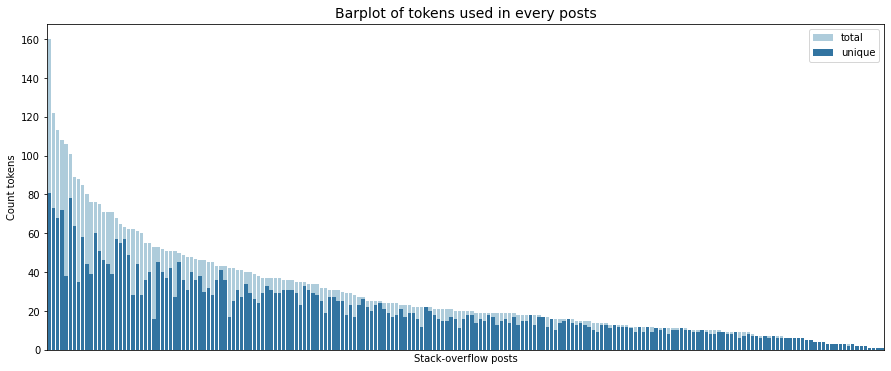

In [41]:
freq4, stats4, corpora4 = from_post_to_tokens(posts_tokens, stopwords=sw)

df_tokens_stats = pd.DataFrame.from_dict(stats4, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens4_radical.jpg"
sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)

Je propose de garder ces premiers traitements pour la suite. je les enregistre pour partir directement d'ici : 

In [42]:
## save results
data_lemmatized = []
for list_text in corpora4.values():
    text  = " ".join(list_text)
    data_lemmatized.append(text)

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

## transform into bag of words : 
# data_vectorized = {}
# for idx in corpora4.keys():
#     list_text = corpora4[idx]
#     text = " ".join(list_text)
#     data_vectorized[idx] = vectorizer.fit_transform(text)
data_vectorized = vectorizer.fit_transform(data_lemmatized)

## save results : 
import pickle

filename = res_path + "tokenization.pkl"
with open(filename, 'wb') as fout:
    pickle.dump((vectorizer, data_vectorized), fout)


In [45]:
import pickle

filename = res_path + "tokenization.pkl"
with open(filename, 'rb') as f:
    vectorizer, data_vectorized = pickle.load(f)


Comme dans le tuto, je regarde la sparcité de ma matrice :

In [46]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.396171662712961 %


<a id ="section1.3"></a>
<a id ="section1.3.1"></a>
[back to menu](#menu)

## 1.C Représentation des mots :

### 1.C.a Bag of Words 

TODO explain

<a id ="section1.3.2"></a>
[back to menu](#menu)

### 1.C.b tf-idf

Tf-idf est [une représentation vectorielle d'un ensemble de mots](https://fr.wikipedia.org/wiki/TF-IDF), où chaque mot est représenté par le nombre de fois où il apparait dans le corpus : si le mort apparait peu de fois, il doit être particulièrement important. 

In [67]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
def my_tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems
tfidf = TfidfVectorizer(tokenizer=my_tokenize, stop_words=[])
data_tfidf = tfidf.fit_transform(data_lemmatized)

In [68]:
print(data_tfidf[0])

  (0, 24914)	0.08797188683405675
  (0, 35078)	0.14433354092332365
  (0, 10923)	0.11351241430181122
  (0, 36415)	0.07797720370309869
  (0, 5660)	0.09003717676644228
  (0, 15078)	0.15834511182669705
  (0, 9730)	0.09644975259509524
  (0, 11271)	0.08981011271607284
  (0, 13000)	0.08448670643617423
  (0, 3321)	0.08644897768491329
  (0, 22329)	0.2057996106489795
  (0, 33433)	0.23813151290569548
  (0, 33465)	0.6107302062121831
  (0, 11414)	0.10023884435046822
  (0, 2180)	0.12593711639473512
  (0, 33427)	0.12586127067740652
  (0, 8504)	0.26099038294651583
  (0, 7241)	0.5034047610758321
  (0, 5698)	0.22797082585178519


<a id ="section1.3.3"></a>
[back to menu](#menu)

### 1.C.c Word to vect

Je me suis ensuite muni d'outils pré-entrainés pour réduire la dimension et la sparcité de ma matrice de design. Pour cela, j'ai utilisé la bibliothèque "gensim", et [le tuto suivant](https://rare-technologies.com/word2vec-tutorial/). 

D'autres bibliothèques de nlp (notamment spacy) proposent une implémentation de ces process.

In [69]:
sentences = data_lemmatized
model = models.Word2Vec(sentences)

In [70]:
## attention : copie pour debug
def lemmatization(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc =  nlp(" ".join(list_tokens)) 
    out = []
    for token in doc : 
        if token.pos_ in allowed_postags: 
            if token.lemma_ not in ['-PRON-']:
                out.append(token.lemma_)
    return out

def from_post_to_tokens_gensim(dict_posts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stopwords=[]):        
    corpora = {}#dict_posts.copy()
    for idx in dict_posts.keys() :
        doc = dict_posts[idx]
        ## preprocess from gensim : 
        tokens = tokenize(doc, lowercase=True, deacc=True, 
                           encoding='utf8', errors='strict')
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
#         tokens = [stemmer.stem(w) for w in tokens]
        ## lemmatization 
        tokens = " ".join(lemmatization(tokens, allowed_postags=allowed_postags))
        ## save results
        corpora[idx] = tokens
    return(corpora)

In [ ]:
corpora_tokens = from_post_to_tokens_gensim(posts, stopwords=sw)

# with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "wb") as f :
#     pickle.dump(corpora_tokens, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "rb") as f :
    corpora = pickle.load(f)
    
sentences = corpora_tokens.values()

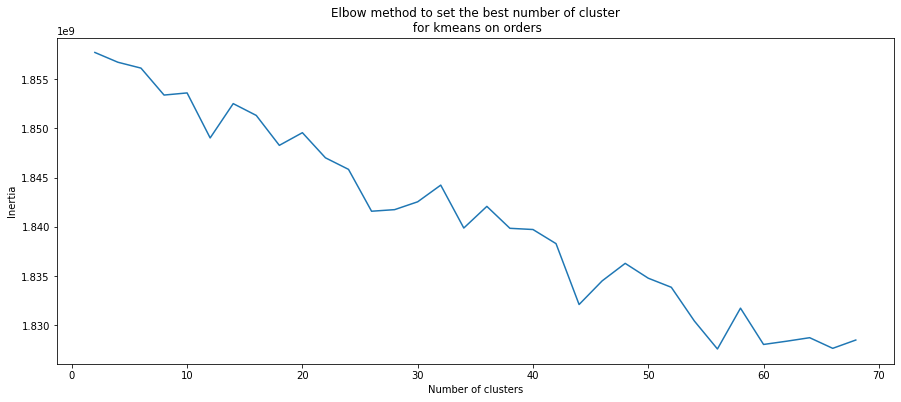

In [50]:
## Standardization : 
my_std = StandardScaler(with_mean=False)#mean false because sparce
X = data_tfidf
my_std.fit(X)
X_std = my_std.transform(X)

list_n_clusters = np.arange(2,70,2)
# Elbow-Method/SSD 
ssd = []
for num_clusters in list_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(X_std)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(list_n_clusters,ssd)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow method to set the best number of cluster\n for kmeans on orders")
plt.savefig(res_path+"figures/"+"tfidf_kmeans_inertia.jpg")
plt.show()

<a id ="section2"></a>
[back to menu](#menu)

# 2. Classification non supervisée